In [35]:
import warnings
from copy import deepcopy
from itertools import zip_longest
from typing import Union, Optional, Callable, Any, Dict, List

import numpy as np
import torch.utils.data as torchdata

from torch.utils.data import Dataset

from baal.active.dataset.base import SplittedDataset

def _identity(x):
    return x

class ActiveLearningDataset(SplittedDataset):
    """A dataset that allows for active learning.

    Args:
        dataset: The baseline dataset.
        labelled: An array that acts as a mask which is greater than 1 for every
            data point that is labelled, and 0 for every data point that is not
            labelled.
        make_unlabelled: The function that returns an
            unlabelled version of a datum so that it can still be used in the DataLoader.
        random_state: Set the random seed for label_randomly().
        pool_specifics: Attributes to set when creating the pool.
                                         Useful to remove data augmentation.
        last_active_steps: If specified, will iterate over the last active steps
                            instead of the full dataset. Useful when doing partial finetuning.
    """

    def __init__(
        self,
        dataset: Dataset,
        labelled: Optional[np.ndarray] = None,
        make_unlabelled: Callable = _identity,
        random_state=None,
        pool_specifics: Optional[dict] = None,
        last_active_steps: int = -1,
    ) -> None:
        self._dataset = dataset

        # The labelled_map keeps track of the step at which an item as been labelled.
        if labelled is not None:
            labelled_map: np.ndarray = labelled.astype(int)
        else:
            labelled_map = np.zeros(len(self._dataset), dtype=int)

        if pool_specifics is None:
            pool_specifics = {}
        self.pool_specifics: Dict[str, Any] = pool_specifics

        self.make_unlabelled = make_unlabelled
        # For example, FileDataset has a method 'label'. This is useful when we're in prod.
        self.can_label = self.check_dataset_can_label()
        super().__init__(
            labelled=labelled_map, random_state=random_state, last_active_steps=last_active_steps
        )

    def check_dataset_can_label(self):
        """Check if a dataset can be labelled.

        Returns:
            Whether the dataset's label can be modified or not.

        Notes:
            To be labelled, a dataset needs a method `label`
            with definition: `label(self, idx, value)` where `value`
            is the label for indice `idx`.
        """
        has_label_attr = getattr(self._dataset, "label", None)
        if has_label_attr:
            if callable(has_label_attr):
                return True
            else:
                warnings.warn(
                    "Dataset has an attribute `label`, but it is not callable."
                    "The Dataset will not be labelled with new labels.",
                    UserWarning,
                )
        return False

    def __getitem__(self, index: int) -> Any:
        """Return items from the original dataset based on the labelled index."""
        index = self.get_indices_for_active_step()[index]
        return self._dataset[index]

    class ActiveIter:
        """Iterator over an ActiveLearningDataset."""

        def __init__(self, aldataset):
            self.i = 0
            self.aldataset = aldataset

        def __len__(self):
            return len(self.aldataset)

        def __next__(self):
            if self.i >= len(self):
                raise StopIteration

            n = self.aldataset[self.i]
            self.i = self.i + 1
            return n

    def __iter__(self):
        return self.ActiveIter(self)

    @property
    def pool(self) -> "ActiveLearningPool":
        """Returns a new Dataset made from unlabelled samples.

        Raises:
            ValueError if a pool specific attribute cannot be set.
        """
        current_dataset = deepcopy(self._dataset)

        for attr, new_val in self.pool_specifics.items():
            if hasattr(current_dataset, attr):
                setattr(current_dataset, attr, new_val)
            else:
                raise ValueError(f"{current_dataset} doesn't have {attr}")

        pool_dataset: torchdata.Subset = torchdata.Subset(
            current_dataset, (~self.labelled).nonzero()[0].reshape([-1]).tolist()
        )
        ald = ActiveLearningPool(pool_dataset, make_unlabelled=self.make_unlabelled)
        return ald

    def label(self, index: Union[list, int], value: Optional[Any] = None) -> None:
        """
        Label data points.
        The index should be relative to the pool, not the overall data.

        Args:
            index: one or many indices to label.
            value: The label value. If not provided, no modification
                                    to the underlying dataset is done.

        Raises:
            ValueError if the indices do not match the values or
             if no `value` is provided and `can_label` is True.
        """
        if isinstance(index, int):
            # We were provided only the index, we make a list.
            index_lst = [index]
            value_lst: List[Any] = [value]
        else:
            index_lst = index
            if value is None:
                value_lst = [value]
            else:
                value_lst = value

        if value_lst[0] is not None and len(index_lst) != len(value_lst):
            raise ValueError(
                "Expected `index` and `value` to be of same length when `value` is provided."
                f"Got index={len(index_lst)} and value={len(value_lst)}"
            )
        indexes = self._pool_to_oracle_index(index_lst)
        active_step = self.current_al_step + 1
        for idx, val in zip_longest(indexes, value_lst, fillvalue=None):
            if self.can_label and val is not None:
                self._dataset.label(idx, val)  # type: ignore
                self.labelled_map[idx] = active_step
            elif self.can_label and val is None:
                raise ValueError(
                    """The dataset is able to label data, but no label was provided.
                                 If this is a research setting, please set the
                                  `ActiveLearningDataset.can_label` to `False`.
                                  """
                )
            else:
                # Regular research usecase.
                self.labelled_map[idx] = active_step
                if val is not None:
                    warnings.warn(
                        "We will consider the original label of this datasample : {}, {}.".format(
                            self._dataset[idx][0], self._dataset[idx][1]
                        ),
                        UserWarning,
                    )

    def reset_labelled(self):
        """Reset the label map."""
        self.labelled_map = np.zeros(len(self._dataset), dtype=np.bool)

    def get_raw(self, idx: int) -> Any:
        """Get a datapoint from the underlying dataset."""
        return self._dataset[idx]

    def state_dict(self) -> Dict:
        """Return the state_dict, ie. the labelled map and random_state."""
        return {"labelled": self.labelled_map, "random_state": self.random_state}

    def load_state_dict(self, state_dict):
        """Load the labelled map and random_state with give state_dict."""
        self.labelled_map = state_dict["labelled"]
        self.random_state = state_dict["random_state"]


In [1]:
from baal.active import ActiveLearningDataset
from aug_lib import TrivialAugment
from baal_extended.ExtendedActiveLearningDataset import ExtendedActiveLearningDataset

In [2]:
from torchvision import datasets
from torchvision.transforms import transforms
import aug_lib
aug_transform = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            aug_lib.TrivialAugment(),
            transforms.ToTensor(),
            transforms.Normalize(3 * [0.5], 3 * [0.5]),
        ]
    )

transform = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(3 * [0.5], 3 * [0.5]),
        ]
    )
train_ds = datasets.CIFAR10(
        ".", train=True, transform=transform,target_transform=None, download=True
    )

aug_train_ds = datasets.CIFAR10(
        ".", train=True, transform=aug_transform,target_transform=None, download=True
    )
#ald_set = ActiveLearningDataset(
#        train_ds, pool_specifics={"transform": transform}
#    )
eald_set = ExtendedActiveLearningDataset(train_ds)

Files already downloaded and verified
Files already downloaded and verified


In [279]:
eald_set.n_unaugmented

50002

In [271]:
len(train_ds)+len(aug_train_ds)+(len(aug_train_ds))

150000

In [273]:
len(eald_set.pool)

150000

In [3]:
eald_set.augment_n_times(2, augmented_dataset=aug_train_ds)
my_list = eald_set.random_state.choice(eald_set.n_unlabelled, 10, replace=False).tolist()
#aug_ids = eald_set.get_augmented_ids_of_image()
#my_list
#eald_set.label(10)


In [274]:
my_list

[93742, 31574, 37230, 118700, 82274, 101346, 44808, 8150, 98685, 25207]

In [4]:
eald_set.is_augmentation(118700)

True

In [264]:
len(eald_set.pool)

200000

In [263]:
eald_set.augmented_map[100001]

1

In [6]:
len(eald_set.pool)

150000

In [7]:
eald_set.label_randomly(150000)

IndexError: index 49482 is out of bounds for axis 0 with size 49249

In [250]:
eald_set._pool_to_oracle_index(174582)

[174585]

In [247]:
eald_set.label(174582)

0: 3


ValueError: The idx given responds to an augmented image, please specify an id that responds to an unaugmented image!

In [248]:
eald_set.get_augmented_ids_of_image(174582)

ValueError: The idx given responds to an augmented image, please specify an id that responds to an unaugmented image!

In [249]:
eald_set.is_augmentation(174582)

True

In [233]:
eald_set._pool_to_oracle_index(my_list)

[35576, 16949, 79062, 81431, 8730, 82812, 29738, 2311, 24378, 15466]

In [224]:
eald_set.n_augmented

49999

In [222]:
eald_set.label_randomly(10)

0: 140
augmented_ids(array([70891]),)
len aug ids1
id is[70891]
type of id is<class 'numpy.ndarray'>
looping through aug_ids, curren id:[70891]
1: 140
2: 141
augmenting source image20891
3: 142
augmented_ids(array([76735]),)
len aug ids1
id is[76735]
type of id is<class 'numpy.ndarray'>
looping through aug_ids, curren id:[76735]
4: 142
5: 143
augmenting source image26735
6: 144
augmented_ids(array([63683]),)
len aug ids1
id is[63683]
type of id is<class 'numpy.ndarray'>
looping through aug_ids, curren id:[63683]
7: 144
8: 145
augmenting source image13683
9: 146
augmented_ids(array([79592]),)
len aug ids1
id is[79592]
type of id is<class 'numpy.ndarray'>
looping through aug_ids, curren id:[79592]
10: 146
11: 147
augmenting source image29592
12: 148
augmented_ids(array([59908]),)
len aug ids1
id is[59908]
type of id is<class 'numpy.ndarray'>
looping through aug_ids, curren id:[59908]
13: 148
14: 149
augmenting source image9908
15: 150
augmented_ids(array([65566]),)
len aug ids1
id is[655

In [83]:
x = eald_set.get_augmented_ids_of_image(5)
idx = None
for a in x:
    print(a)
    idx = eald_set._oracle_to_pool_index(a)
idx

idx5 augMapVal:0 augMapType:<class 'numpy.int64'>
[]


[]

In [55]:
print(eald_set.can_augment())
print(eald_set.n_unaugmented)
print(eald_set.n_augmented)
print(len(eald_set.pool))
eald_set.augment_n_times(1, augmented_dataset=aug_train_ds)
print(len(eald_set._dataset))
print(eald_set.get_augmented_ids_of_image(5))
print(eald_set.is_augmentation(5))
print(eald_set.is_augmentation(50005))
print(len(eald_set))
eald_set.label(7)


True
50000
0
50000
100000
idx5 augMapVal:0 augMapType:<class 'numpy.int64'>
(array([50005]),)
idx5 augMapVal:0 augMapType:<class 'numpy.int64'>
False
idx50005 augMapVal:5 augMapType:<class 'numpy.int64'>
False
0
[7]
idx7 augMapVal:0 augMapType:<class 'numpy.int64'>
idx7 augMapVal:0 augMapType:<class 'numpy.int64'>


In [39]:
eald_set.label(9)

augMapVal:0 augMapType:<class 'numpy.int64'>
augMapVal:0 augMapType:<class 'numpy.int64'>


In [52]:
len(eald_set)

100000

In [60]:
eald_set.n_labelled

100000

In [58]:
my_list = eald_set.random_state.choice(eald_set.n_unlabelled, 10, replace=False).tolist()
my_list

[94241, 79564, 83187, 41291, 1826, 47424, 26698, 94918, 88774, 79590]

In [59]:
eald_set.label(my_list)

[94243, 79566, 83189, 41292, 1827, 47425, 26699, 94920, 88776, 79592]
idx94243 augMapVal:44243 augMapType:<class 'numpy.int64'>
idx94243 augMapVal:44243 augMapType:<class 'numpy.int64'>


IndexError: index 94241 is out of bounds for axis 0 with size 0

In [194]:
eald_set.label_randomly(10)

0: 2


IndexError: invalid index to scalar variable.

In [29]:
idx = 5
idx = [idx]
for id in idx:
    print(id)

[5]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


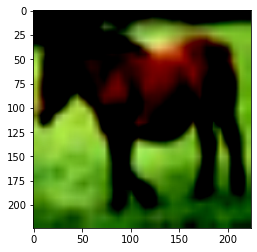

In [44]:
import matplotlib.pyplot as plt
plt.imshow(eald_set[1][0].permute(1,2,0))



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


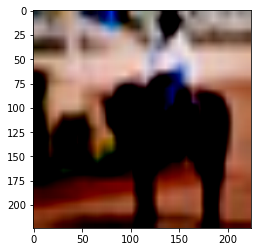

In [153]:
plt.imshow(eald_set[2][0].permute(1,2,0))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


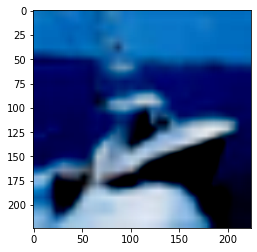

In [80]:
plt.imshow(eald_set.pool[100005][0].permute(1,2,0))

In [53]:
eald_set[5]

IndexError: list index out of range

In [82]:
arr = np.arange(5)

In [86]:
len(arr)

conarr = np.concatenate((arr, arr))

In [91]:
len(conarr)
print(conarr)
ids = np.where(conarr == 0)
print(ids)
conarr[5]

[0 1 2 3 4 0 1 2 3 4]
(array([0, 5]),)


0

## next steps

[X] fix pool command
[X] enable labelling for augmented images
- implement trivialaug
- implement tests for my functions
[X] write helper functions, to get all augmentation to one picture

[] label randomly on augmented datasets